<a href="https://colab.research.google.com/github/jha04amartya/Emotion-to-emoji-cnn-webapp-/blob/main/llm_detect_ai_generated_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# After running this cell, you'll be prompted to authenticate and authorize Google Drive access.

# Now, you can access your Google Drive content under the '/content/drive' directory in Colab.
# You can create, read, and write files in this directory, making it a convenient way to store and retrieve data.


Mounted at /content/drive



<div style="padding:20px;
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#4FC95F;
            overflow:hidden;
            font-weight:500">LLM - Detect AI Generated Text</div>

In [2]:
# LIBRARIES
!pip install keras_core
# Global
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import regex as re

# Function to plot WordCloud
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

# Tensorflow/Keras
import tensorflow as tf
import keras_core as keras
from keras import layers, Sequential
from keras.layers import TextVectorization
from keras.callbacks import (ModelCheckpoint,
                             EarlyStopping,
                             ReduceLROnPlateau,
                             CSVLogger,
                             LearningRateScheduler)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, precision_recall_curve,
                             roc_curve, auc)

os.environ["KERAS_BACKEND"] = "tensorflow"  # or "tensorflow" or "torch"

# Set Seed for Reproducibility
keras.utils.set_random_seed(42)

# Use mixed precision to speed up all training.
keras.mixed_precision.set_global_policy("mixed_float16")

# Check Versions
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 5.2 MB/s eta 0:00:00
Using TensorFlow backend
TensorFlow: 2.15.0
Keras: 0.1.7


In [3]:
def compress(df, verbose=True):
    """
    Reduces the size of the DataFrame by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum() / (1024 ** 2)
    if verbose:
        print("Old dataframe size:", round(input_size, 2), 'MB')

    in_size = df.memory_usage(index=True).sum()
    dtype_before = df.dtypes.copy()  # Copy of original data types

    for col in df.select_dtypes(include=['float64', 'int64']):
        col_type = df[col].dtype
        col_min, col_max = df[col].min(), df[col].max()

        if col_type == 'int64':
            if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        elif col_type == 'float64':
            ## float16 warns of overflow
            # if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
            #     df[col] = df[col].astype(np.float16)
            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            elif col_min > np.finfo(np.float64).min and col_max < np.finfo(np.float64).max:
                df[col] = df[col].astype(np.float64)

    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    if verbose:
        print("Optimized size by {}%".format(round(ratio, 2)))
        print("New DataFrame size:", round(out_size / (1024 ** 2), 2), "MB")

    # Filter only numerical columns for comparison
    numeric_columns = df.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32', 'int64'])
    dtype_after = numeric_columns.dtypes.copy()  # Copy of data types after compression

    # Create a comparison DataFrame
    comparison_df = pd.DataFrame({'Before': dtype_before[numeric_columns.columns], 'After': dtype_after})
    comparison_df['Size Reduction'] = ratio

    return df, comparison_df

In [4]:
# Generate WordCloud

def generate_wordcloud_subplot(df, label_value, subplot_position, max_words=1000, width=800, height=400, top_n = 10):
    """
    Generate a word cloud for a specific label value and display it in a subplot.

    Args:
        df (DataFrame): The DataFrame containing text data and labels.
        label_value (int): The label value for which to generate the word cloud.
        subplot_position (int): The position of the subplot where the word cloud will be displayed.
        max_words (int, optional): Maximum number of words to include in the word cloud. Default is 1000.
        width (int, optional): Width of the word cloud image. Default is 800.
        height (int, optional): Height of the word cloud image. Default is 400.

    Returns:
        None
    """

    # Select the text subset for the specified label value
    text_subset = df[df.generated == label_value].text

    # Define stopwords to be excluded
    stopwords = set(STOPWORDS)

    # Create a WordCloud object with specified parameters
    wc = WordCloud(max_words=max_words, width=width, height=height, stopwords=stopwords)

    # Generate the word cloud from the selected text subset
    wc.generate(" ".join(text_subset))

    # Create a subplot and display the word cloud
    plt.subplot(subplot_position)
    plt.imshow(wc, interpolation='bilinear')

    # Set the title for the word cloud plot
    title = f'WordCloud for Label {label_value} ({("Student" if label_value == 0 else "AI")})'
    plt.title(title)

    # Count occurrences of words in the text subset
    words_count = Counter(" ".join(text_subset).split())
    top_words = words_count.most_common(top_n)
    bottom_words = words_count.most_common()[:-top_n-1:-1]  # Extract least common words

    # Print the most common words
    print(f"Top {top_n} words for Label {label_value}:")
    for idx, (word, count) in enumerate(top_words, start=1):
        print(f"{idx}. {word}: {count} times")
    print("------------------------------")

    # Print the least common words
    print(f"Least {top_n} words for Label {label_value}:")
    for idx, (word, count) in enumerate(bottom_words, start=1):
        print(f"{idx}. {word}: {count} times")
    print("------------------------------")

In [5]:
# Import Data

data_path = '/content/drive/MyDrive/data_vlg'

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


If we load the train dataset we see that it contains 1378 essays.

In [6]:
# Essays Train Dataset

df_train_essays = pd.read_csv('/content/drive/MyDrive/data_vlg /train_essays.csv')

print(df_train_essays.info())
df_train_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [7]:
# Compression

# Compress dataframe
df_train_essays, comparison_df = compress(df_train_essays, verbose=True)

# Check compression
comparison_df

Old dataframe size: 0.04 MB
Optimized size by 44.0%
New DataFrame size: 0.02 MB


,Before,After,Size Reduction
prompt_id,int64,int8,44.0
generated,int64,int8,44.0


In [8]:
# Checking the first essay text

df_train_essays.text[0]

'Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.\n\nIn like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article

### <font color='289C4E'>3.1.2. Test Set 🧪<font><a class='anchor' id='essaystest'></a> [↑](#top)

If we load the test dataset we see that it only contains 3 essays. Additionally, the text only contains 12 characters. However the test set used for evaluation contains more essays.

In [9]:
# Essays Test Dataset

df_test_essays = pd.read_csv('/content/drive/MyDrive/data_vlg /test_essays.csv')

print(df_test_essays.info())
df_test_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None


,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [10]:
# Compression

# Compress dataframe
df_test_essays, comparison_df = compress(df_test_essays, verbose=True)

# Check compression
comparison_df

Old dataframe size: 0.0 MB
Optimized size by 10.0%
New DataFrame size: 0.0 MB


,Before,After,Size Reduction
prompt_id,int64,int8,10.0


In [11]:
# Checking the first essay text

df_test_essays.text[0]

'Aaa bbb ccc.'

In [12]:
# Checking length of the essays

df_test_essays["text"].apply(lambda x : len(x))

0    12
1    12
2    12
Name: text, dtype: int64

In [13]:
# Prompts Dataset

df_train_prompts = pd.read_csv('/content/drive/MyDrive/data_vlg /train_prompts.csv')
print(df_train_prompts.info())

df_train_prompts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 192.0+ bytes
None


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [14]:
# Compression

# Compress dataframe
df_train_prompts, comparison_df = compress(df_train_prompts, verbose=True)

# Check compression
comparison_df

Old dataframe size: 0.0 MB
Optimized size by 7.0%
New DataFrame size: 0.0 MB


,Before,After,Size Reduction
prompt_id,int64,int8,7.0


In [15]:
# Checking the first instruction given to students

df_train_prompts.instructions[0]

'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.'

In [16]:
# Checking the first text

df_train_prompts.source_text[0]

'# In German Suburb, Life Goes On Without Cars by Elisabeth Rosenthal\n\n1 VAUBAN, Germany—Residents of this upscale community are suburban pioneers, going where few soccer moms or commuting executives have ever gone before: they have given up their cars.\n\n2 Street parking, driveways and home garages are generally forbidden in this experimental new district on the outskirts of Freiburg, near the French and Swiss borders. Vauban’s streets are completely “car-free”—except the main thoroughfare, where the tram to downtown Freiburg runs, and a few streets on one edge of the community. Car ownership is allowed, but there are only two places to park—large garages at the edge of the development, where a car-owner buys a space, for $40,000, along with a home.\n\n3 As a result, 70 percent of Vauban’s families do not own cars, and 57 percent sold a car to move here. “When I had a car I was always tense. I’m much happier this way,” said Heidrun Walter, a media trainer and mother of two, as she 

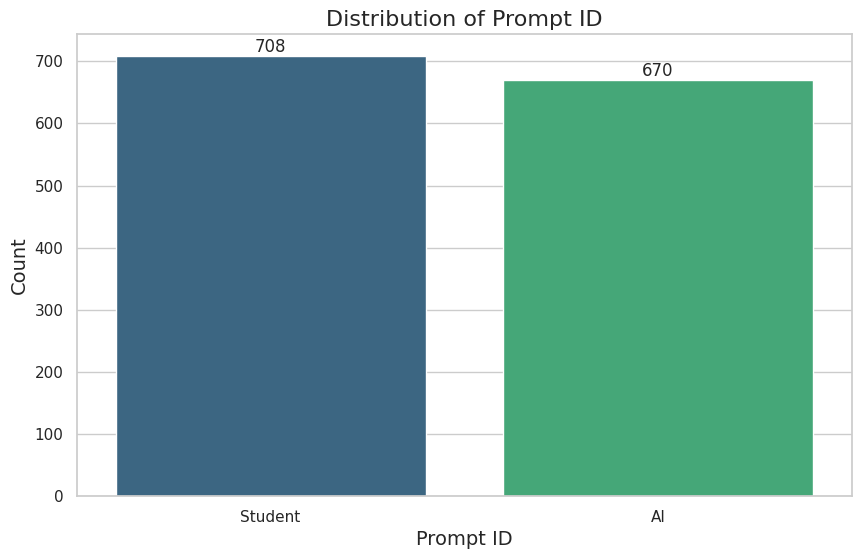

In [17]:
# Distribution of Prompts

# Set Figure
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create the count plot
ax = sns.countplot(data=df_train_essays, x="prompt_id", palette="viridis")

# Mapping x-axis labels
ax.set_xticklabels(["Student", "AI"])

# Obtaining and setting the count values
abs_values = df_train_essays['prompt_id'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=12)

# Set title and labels with increased font sizes
ax.set_title("Distribution of Prompt ID", fontsize=16)
ax.set_xlabel("Prompt ID", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

plt.show()

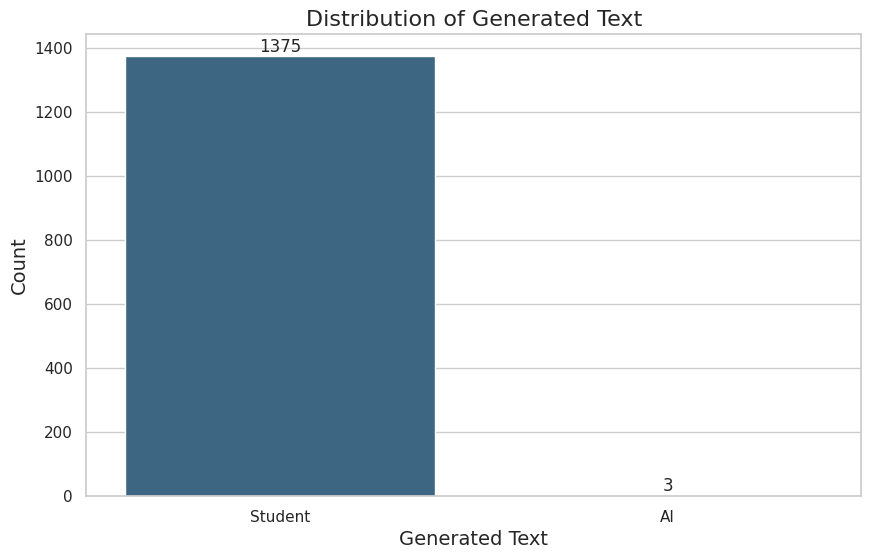

In [18]:
# Distribution of Generated Text

# Set Figure
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create the count plot
ax = sns.countplot(data=df_train_essays, x="generated", palette="viridis")

# Mapping x-axis labels
ax.set_xticklabels(["Student", "AI"])

# Obtaining and setting the count values
abs_values = df_train_essays['generated'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=12)

# Set title and labels with increased font sizes
ax.set_title("Distribution of Generated Text", fontsize=16)
ax.set_xlabel("Generated Text", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

plt.show()

In [19]:
#Import external dataset

ext1 = pd.read_csv('/content/drive/MyDrive/data_vlg /train_v2_drcat_02.csv')

In [20]:
ext1.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [21]:
# Check duplicates

# Get the number of rows with duplicates
duplicates = ext1.duplicated().sum()

# Print the number of rows before and after
print(f"Number of rows with duplicates: {duplicates}")

Number of rows with duplicates: 0


In [22]:
# Compression

# Compress dataframe
ext1, comparison_df = compress(ext1, verbose=True)

# Check compression
comparison_df

Old dataframe size: 1.41 MB
Optimized size by 21.0%
New DataFrame size: 1.11 MB


,Before,After,Size Reduction
label,int64,int8,21.0


In [23]:
# Drop Columns

ext1.drop(["RDizzl3_seven", "prompt_name", "source", "prompt_name"], inplace=True, axis=1)

ext1.head()

,text,label
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


In [24]:
# Rename label column

ext1.rename(columns = {"label":"generated"}, inplace=True)

ext1.head()

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


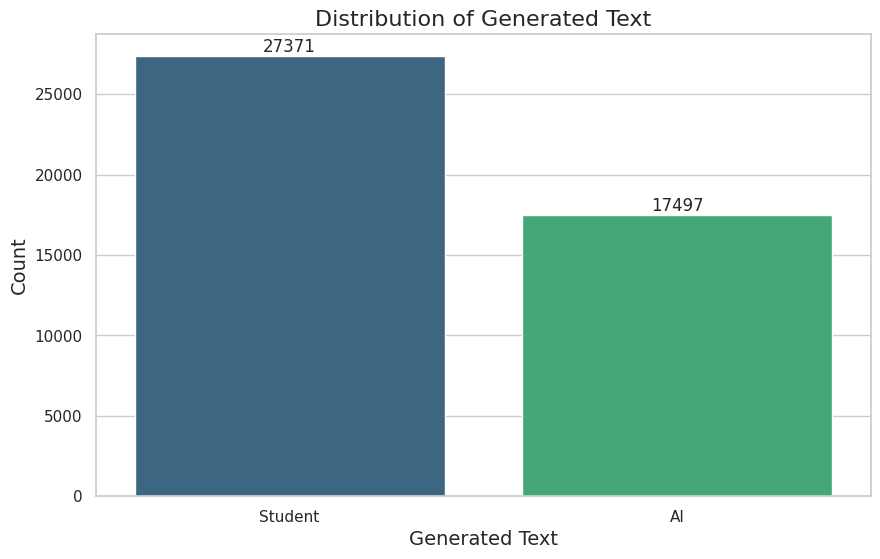

In [25]:
# Distribution of Generated Text in the External Dataset

# Set Figure
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create the count plot
ax = sns.countplot(data=ext1, x="generated", palette="viridis")

# Mapping x-axis labels
ax.set_xticklabels(["Student", "AI"])

# Obtaining and setting the count values
abs_values = ext1['generated'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values, fontsize=12)

# Set title and labels with increased font sizes
ax.set_title("Distribution of Generated Text", fontsize=16)
ax.set_xlabel("Generated Text", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

plt.show()

Top 10 words for Label 1:
1. to: 210391 times
2. and: 207318 times
3. the: 205134 times
4. a: 142997 times
5. of: 132836 times
6. in: 85734 times
7. can: 81521 times
8. that: 77453 times
9. is: 74384 times
10. for: 58432 times
------------------------------
Least 10 words for Label 1:
1. administer: 1 times
2. ratified.: 1 times
3. 55.7%,: 1 times
4. donors.: 1 times
5. Nebraska).: 1 times
6. (Maine: 1 times
7. Representatives).: 1 times
8. 3.8: 1 times
9. 578,000: 1 times
10. 49%: 1 times
------------------------------
Top 10 words for Label 0:
1. the: 488916 times
2. to: 410350 times
3. and: 268688 times
4. a: 268355 times
5. of: 219057 times
6. that: 176860 times
7. is: 168992 times
8. in: 158714 times
9. be: 130641 times
10. you: 127159 times
------------------------------
Least 10 words for Label 0:
1. States.According: 1 times
2. aboutinstead: 1 times
3. bumpertobumper: 1 times
4. 2005": 1 times
5. hybridelectric: 1 times
6. winnertakeitall: 1 times
7. world.Source: 1 times
8. pl

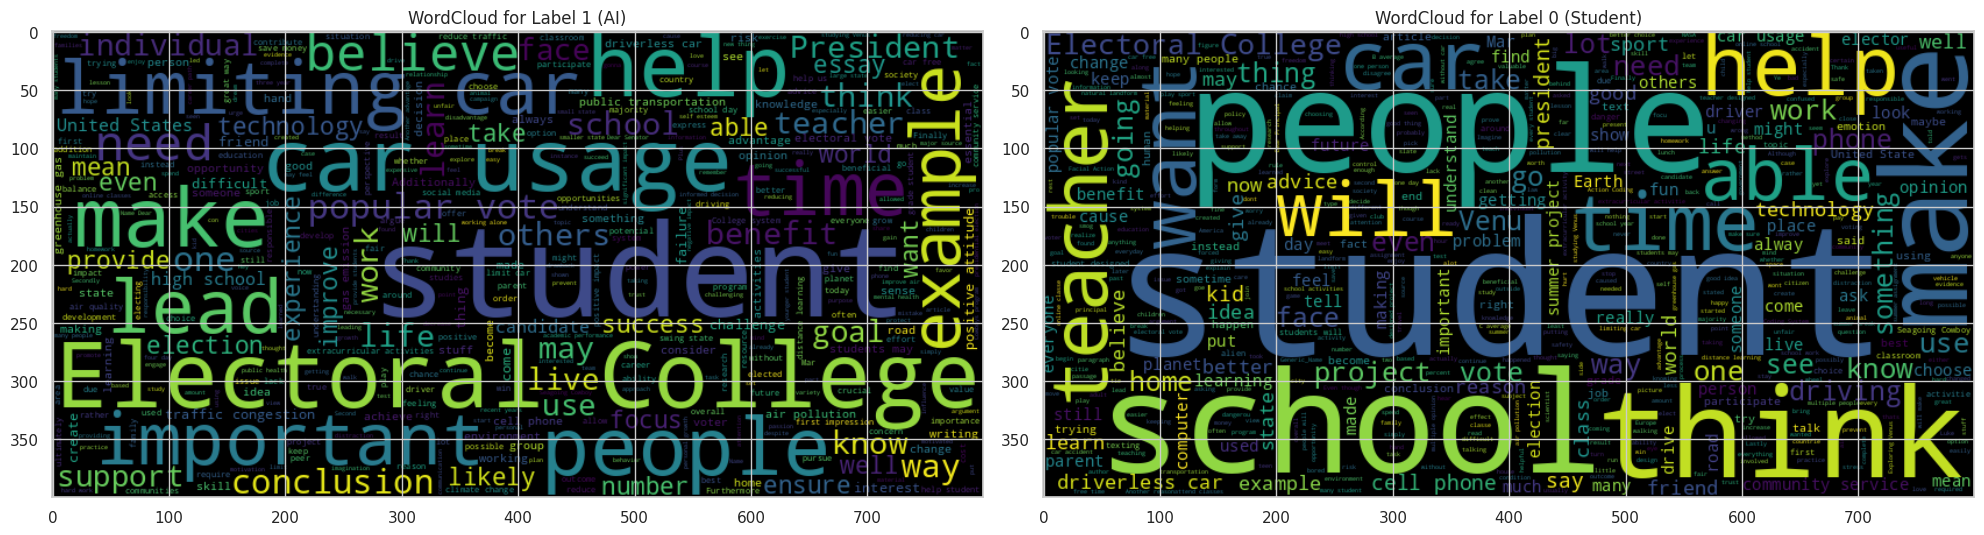

In [26]:
# Plot WordCloud

# Create a 1x2 grid of subplots
plt.figure(figsize=(20, 10))

# Generate WordCloud for label_value = 1 (subplot 1)
generate_wordcloud_subplot(ext1, label_value=1, subplot_position=121, top_n = 10)

# Generate WordCloud for label_value = 0 (subplot 2)
generate_wordcloud_subplot(ext1, label_value=0, subplot_position=122, top_n = 10)

plt.tight_layout()  # Adjust spacing between subplots

plt.show()

There are several preprocessing steps that we will perform:

* Clean text: lower text, removal of punctiation, extra spaces, whitespaces and numbers

* Stopwords removal

This will help to feed the model with mode relevant information.

In [27]:
# Clean Text

def clean_text(text):
    # Replace actual newline and carriage return characters with whitespace
    text = text.replace("\n", " ")
    text = text.replace("\r", " ")

    # Drop punctuation
    text = re.sub(r"\p{P}", " ", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)

    # Remove leading and trailing whitespace
    text = text.strip()

    # Lower text
    text = text.lower()

    # Remove numbers
    text = re.sub(r"\d+", "", text)

    return text

# Apply the clean_text function to the 'text' column in the DataFrame
ext1['text'] = ext1['text'].apply(clean_text)

# Change contractions
contractions = {
    r'\b(can\'t)\b': 'cannot',
    r'\b(don\'t)\b': 'do not',
    r'\b(won\'t)\b': 'will not',
}

# Iterate through contractions and apply replacements to the entire DataFrame column
for pattern, replacement in contractions.items():
    ext1['text'] = ext1['text'].apply(lambda x: re.sub(pattern, replacement, x, flags=re.IGNORECASE))


In [28]:
# As NLTK is not working in Kaggle. We set the stopwords list

stopword_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
len(stopword_list)

179

In [29]:
# Remove Stopwords

def remove_custom_stopwords(sentence):
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stopword_list]
    return ' '.join(filtered_words)

# Apply the function to the 'text' column
ext1['text'] = ext1['text'].apply(remove_custom_stopwords)

In [30]:
# Check duplicates

# Get the number of rows with duplicates
duplicates = ext1.duplicated().sum()

# Print the number of rows before and after
print(f"Number of rows with duplicates: {duplicates}")

Number of rows with duplicates: 16


After preprocessing if we plot the stopwords again, we see that the list of works looks more relevant and this will improve the results of our model.

Top 10 words for Label 1:
1. students: 40987 times
2. like: 25589 times
3. also: 23740 times
4. people: 23396 times
5. help: 21912 times
6. car: 21197 times
7. school: 19871 times
8. may: 19863 times
9. electoral: 18685 times
10. time: 18407 times
------------------------------
Least 10 words for Label 1:
1. unitary: 1 times
2. uncompetitive: 1 times
3. voiceless: 1 times
4. overrepresent: 1 times
5. tiered: 1 times
6. delegitimize: 1 times
7. provisional: 1 times
8. disgrace: 1 times
9. nationalization: 1 times
10. middleman: 1 times
------------------------------
Top 10 words for Label 0:
1. students: 95870 times
2. would: 76850 times
3. people: 73610 times
4. school: 59501 times
5. could: 42543 times
6. get: 42223 times
7. like: 37923 times
8. car: 37803 times
9. one: 37735 times
10. help: 36894 times
------------------------------
Least 10 words for Label 0:
1. aboutinstead: 1 times
2. bumpertobumper: 1 times
3. hybridelectric: 1 times
4. winnertakeitall: 1 times
5. rollingalong: 1

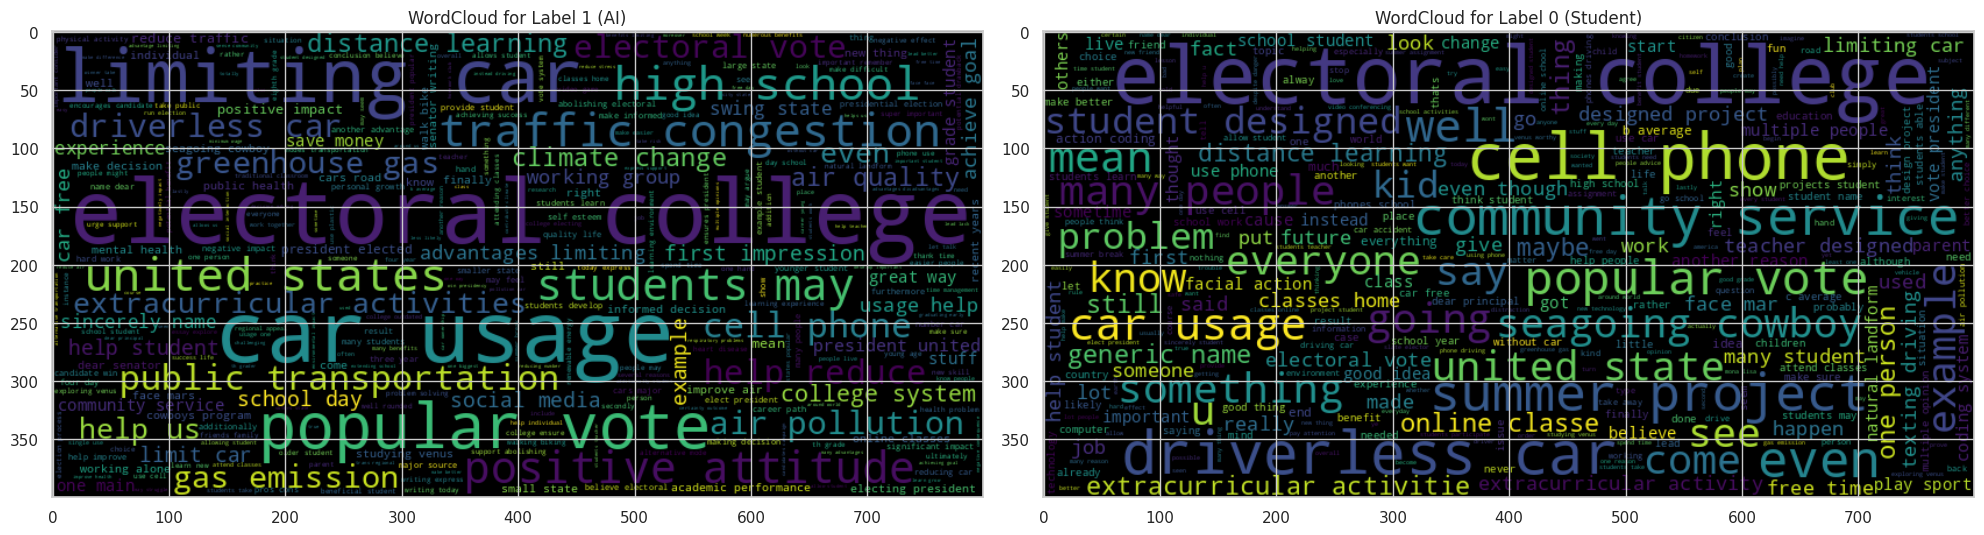

In [31]:
# Plot WordCloud

# Create a 1x2 grid of subplots
plt.figure(figsize=(20, 10))

# Generate WordCloud for label_value = 1 (subplot 1)
generate_wordcloud_subplot(ext1, label_value=1, subplot_position=121, top_n = 10)

# Generate WordCloud for label_value = 0 (subplot 2)
generate_wordcloud_subplot(ext1, label_value=0, subplot_position=122, top_n = 10)


plt.tight_layout()  # Adjust spacing between subplots

plt.show()

Now that we have our dataset clean let's perform our training with an Neural Network model. First, let's make a copy of the final dataset.

In [32]:
# Copy the final_df as df_model

df_model = ext1.copy()

df_model.generated.value_counts()

0    27371
1    17497
Name: generated, dtype: int64

First we will split the dataset in train, test and validation. We will do it after shuffling it, so that we get a good label distribution.

In [ ]:
# Create a shuffled df for a good labels distribution

# Set a random seed for reproducibility
random_seed = 42

print("Before shuffling:", df_model.shape)

# Shuffle the DataFrame with the specified random seed
shuffled_df = df_model.sample(frac=1, random_state=random_seed)

print("After shuffling:", df_model.shape)

Before shuffling: (44868, 2)
After shuffling: (44868, 2)


In [ ]:
# Create a train/val/test split
X = shuffled_df["text"]
y = shuffled_df["generated"]


# Split the data into train, validation, and test sets (80% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_seed)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

# Display the shapes of the train, validation, and test sets
print("X_train shape:", X_train.shape)
print("X_validation shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_validation shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (31407,)
X_validation shape: (6730,)
X_test shape: (6731,)
y_train shape: (31407,)
y_validation shape: (6730,)
y_test shape: (6731,)


If we see the distributions of the labels, we can appreciate a similar distribution in each set, which will help to a better performance of the model.

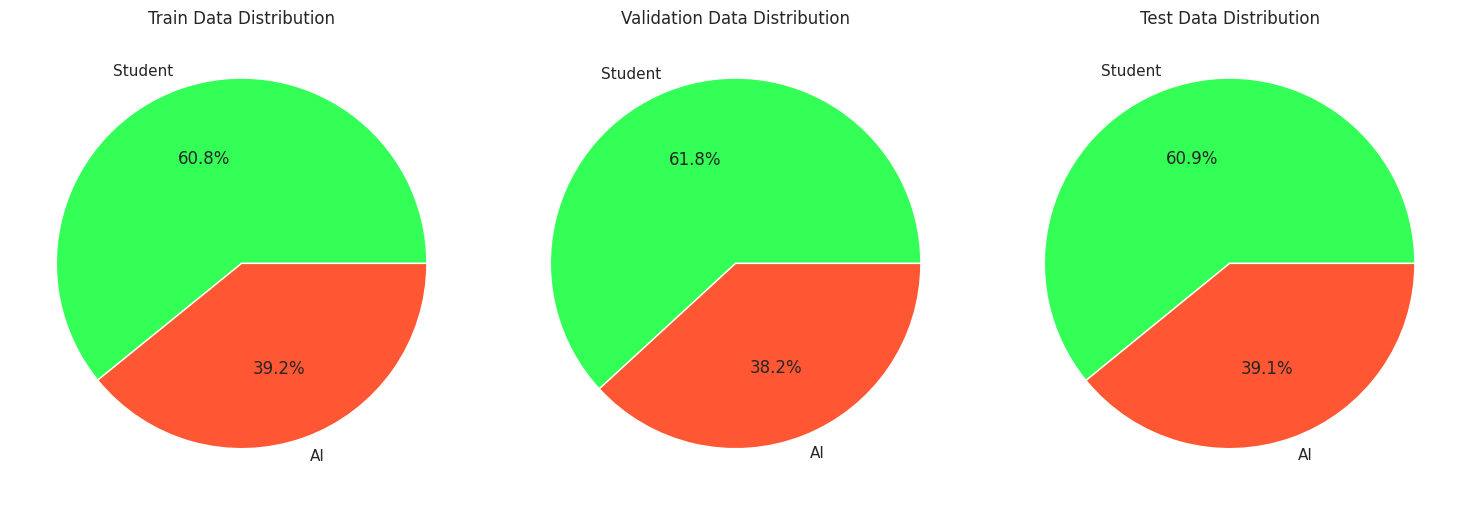

In [ ]:
# Get label counts for train, validation, and test data
train_label_counts = y_train.value_counts()
val_label_counts = y_val.value_counts()
test_label_counts = y_test.value_counts()

# Define custom labels for visualization
custom_labels = {0: 'Student', 1: 'AI'}

# Replace labels for visualization purposes
train_labels_visual = train_label_counts.rename(custom_labels)
val_labels_visual = val_label_counts.rename(custom_labels)
test_labels_visual = test_label_counts.rename(custom_labels)

# Define custom colors for each label
label_colors = {'Student': '#33FF57', 'AI': '#FF5733'}

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1: Train data distribution
wedges, texts, autotexts = axes[0].pie(train_labels_visual, labels=train_labels_visual.index, autopct='%1.1f%%', colors=[label_colors[label] for label in train_labels_visual.index])
axes[0].set_title('Train Data Distribution')

# Subplot 2: Validation data distribution
wedges, texts, autotexts = axes[1].pie(val_labels_visual, labels=val_labels_visual.index, autopct='%1.1f%%', colors=[label_colors[label] for label in val_labels_visual.index])
axes[1].set_title('Validation Data Distribution')

# Subplot 3: Test data distribution
wedges, texts, autotexts = axes[2].pie(test_labels_visual, labels=test_labels_visual.index, autopct='%1.1f%%', colors=[label_colors[label] for label in test_labels_visual.index])
axes[2].set_title('Test Data Distribution')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


For the vestorization we will use the **TextVectorization** layer from TensorFlow. This process prepares text data for input into a machine learning model by converting text into numerical representations that the model can work with.

In [ ]:
# Check the max vocaulary size

text_vectorizer = TextVectorization(split="whitespace",
                                    output_mode="int")

# Fit the text vectorizer
text_vectorizer.adapt(X)

# Get the number of unique tokens in the vocabulary
vocab_size = len(text_vectorizer.get_vocabulary())

# Print the vocabulary size
print("Vocabulary size:", vocab_size)

Vocabulary size: 76851


In [ ]:
# Setup text vectorization with custom variables

# Set the maximum vocabulary size
# max_vocab_size = 10000
max_vocab_size = vocab_size

# Calculate the maximum sequence length based on the average number of tokens in training data
average_tokens_per_sequence = round(sum([len(text.split()) for text in X_train]) / len(X_train))

# Create and configure the TextVectorization layer
text_vectorizer = TextVectorization(
    max_tokens=max_vocab_size,
#     ngrams=(3,5),
    output_mode="int",
    output_sequence_length=average_tokens_per_sequence,
    pad_to_max_tokens=True
)

# Adapt the TextVectorization layer to the training text
if len(X_train) > 0:
    text_vectorizer.adapt(X_train)
else:
    print("Warning: X_train is empty, adaptation skipped.")

After vectorization we will create an **Embedding** layer. This Embedding layer converts input text data (represented as indices or sequences of integers) into dense vectors of fixed size (output_dim) in the embedding space. These dense vectors serve as the input for subsequent layers in the neural network model, allowing the model to learn meaningful representations of words based on their contexts within the input sequences.

In [ ]:
tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_size,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=average_tokens_per_sequence)

Our baseline model is set up for binary classification tasks where the input is text data, and the objective is to predict a binary outcome (Student or AI generated). The text is tokenized, embedded, and then processed through a simple neural network architecture for classification. We have added som callbacks for better performance.

In [ ]:
# Build the model

inputs = layers.Input(shape=(1,), dtype="string")

x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

keras_model = tf.keras.Model(inputs, outputs)

# Compile model
keras_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

# Get a summary of the model
keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 195)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 195, 128)          9836928   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9837057 (37.53 MB)
Trainable params: 9837057 (3

In [ ]:
# Fit the model

callbacks = [ModelCheckpoint(filepath='keras_model', save_best_only=True, save_format='tf'),
             EarlyStopping(patience=7, monitor='val_loss', restore_best_weights = True),
             ReduceLROnPlateau(factor=0.2, patience=5, monitor='val_loss'),
             CSVLogger('keras_training_log.csv')]


keras_model_history = keras_model.fit(X_train,
                                      y_train,
                                      epochs=20,
                                      validation_data=(X_val, y_val),
                                      callbacks=callbacks,
                                     # batch_size=32
                                     )

Epoch 1/20
982/982 [==============================] - 10s 10ms/step - loss: 0.0251 - accuracy: 0.9939 - val_loss: 0.0268 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 2/20
982/982 [==============================] - 12s 12ms/step - loss: 0.0154 - accuracy: 0.9967 - val_loss: 0.0225 - val_accuracy: 0.9932 - lr: 0.0010
Epoch 3/20
982/982 [==============================] - 12s 12ms/step - loss: 0.0100 - accuracy: 0.9982 - val_loss: 0.0201 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 4/20
982/982 [==============================] - 11s 11ms/step - loss: 0.0066 - accuracy: 0.9989 - val_loss: 0.0195 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 5/20
982/982 [==============================] - 12s 12ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.0191 - val_accuracy: 0.9936 - lr: 0.0010
Epoch 6/20
982/982 [==============================] - 11s 11ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0200 - val_accuracy: 0.9939 - lr: 0.0010
Epoch 7/20
982/982 [==============================] - 9s 9

This **learning curves** helps in assessing the model's training progress and observing the trend of both training and validation losses over epochs. We can appreciate that the learning curves are shwoing a good trend and low values. However, the fit very fast and show some overfitting.

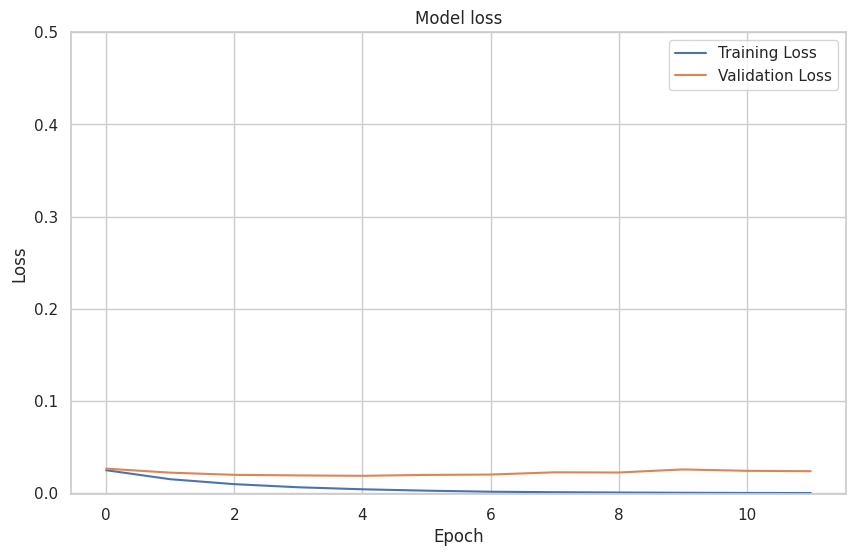

In [ ]:
# Plot learning curves

plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(keras_model_history.history['loss'], label='Training Loss')
plt.plot(keras_model_history.history['val_loss'], label='Validation Loss')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# Set y-axis lower limit to 0.5
plt.ylim(top=0.5)

plt.show()


The **confusion matrix** aids in understanding the model's accuracy in predicting each class and the misclassifications made by the model on the test dataset (X_test). In our case we get excellent results with low amount of FP/FN.

In [ ]:
# Make predictions on input data (X_test) in form of probabilities

keras_probabilities = keras_model.predict(X_test)
keras_probabilities[:5]

211/211 [==============================] - 1s 3ms/step


array([[2.0347093e-07],
       [9.9999678e-01],
       [6.5434332e-11],
       [5.6862389e-04],
       [5.0790609e-06]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats

# squeeze removes single dimensions
keras_prediction = tf.squeeze(tf.round(keras_probabilities))
keras_prediction[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0., 1., 1., 0., 0.], dtype=float32)>

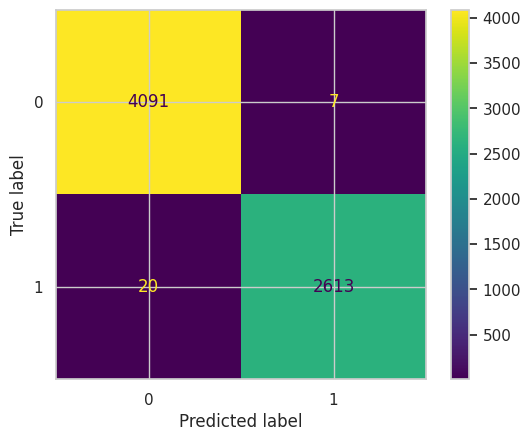

In [ ]:
# Plot confusion matrix

keras_cm = confusion_matrix(y_test, keras_prediction)
keras_cm_plot =ConfusionMatrixDisplay(confusion_matrix=keras_cm)

keras_cm_plot.plot()
plt.show()

This **classification report** evaluates the model's performance using classification metrics and provides insights into its precision, recall, and f1-score for each class, helping to assess how well the model performs in classifying instances in the test dataset (X_test). In our case we get excellent results in all the parameters (precision, recall, f1-score and accuracy)

In [ ]:
# Predictions from the model on the test set
y_pred = keras_model.predict(X_test)

# Converting probabilities to classes (assuming a threshold of 0.5)
y_pred_classes = (y_pred > 0.5).astype(int)

# Printing the classification report
print(classification_report(y_test, y_pred_classes))

211/211 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4098
           1       1.00      0.99      0.99      2633

    accuracy                           1.00      6731
   macro avg       1.00      1.00      1.00      6731
weighted avg       1.00      1.00      1.00      6731



The **ROC curve**, illustrates the trade-off between the true positive rate and false positive rate across different thresholds. The AUC value quantifies the overall performance of the model in distinguishing between the positive and negative classes, with a higher AUC indicating better performance. In our case, again the results are excellent. Note that this is the metric use to evaluate the model performance.

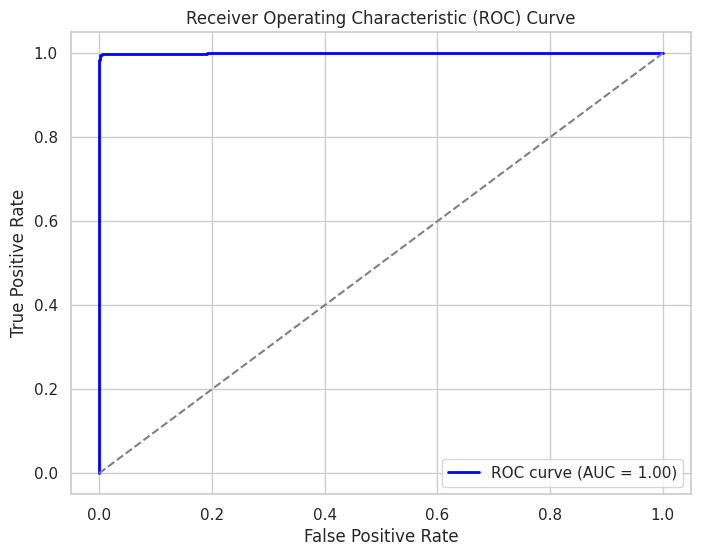

In [ ]:
# AUC -  ROC Curve

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set title and legend
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()


The **precision-recall curve** illustrates the trade-off between precision and recall for different probability thresholds. A higher AUC value indicates better performance of the model in terms of both precision and recall for different classification thresholds. This curve provides valuable insights into the model's performance, especially in scenarios with imbalanced class distributions. In our case, again the results are excellent.

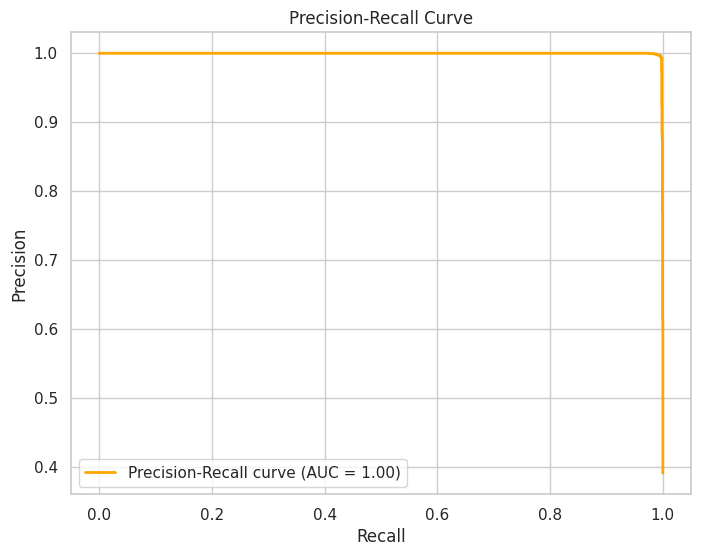

In [ ]:
# Precission-recall curve

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, keras_probabilities)

# Calculate AUC for precision-recall curve
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='orange', lw=2, label='Precision-Recall curve (AUC = {:.2f})'.format(pr_auc))

# Set labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# Set title and legend
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)

plt.show()

Let's submit our baseline model predictions!!

In [ ]:
test_prediction = keras_model.predict(df_test_essays["text"])
test_prediction

1/1 [==============================] - 0s 28ms/step


array([[0.7473057],
       [0.7644138],
       [0.7644138]], dtype=float32)

In [ ]:
# Create a DataFrame to store the submission
submission_df = df_test_essays[["id"]].copy()

# Add the formatted predictions to the submission DataFrame
submission_df["generated"] = test_prediction.squeeze()

# Save Submission
submission_df.to_csv('submission.csv',index=False)

# Display the first 2 rows of the submission DataFrame
submission_df.head()

,id,generated
0,0000aaaa,0.747306
1,1111bbbb,0.764414
2,2222cccc,0.764414
